# Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from functools import reduce
df_tptp = pd.read_csv("data/df_tptp.csv", index_col=0)
counter_columns = ["n_formulae", "n_atoms", "n_clauses", "n_literals", "n_variables"]

df_tptp[counter_columns].describe()
quantiles = df_tptp[counter_columns].quantile(.75)
display(quantiles)
# df_tptp["isLarge"] = df_tptp.apply(lambda row: reduce(lambda x,y: x|y, [ row[colname] > quantiles[colname] for colname in counter_columns ]), axis=1)
large_problems = df_tptp\
    .loc[reduce(lambda x,y: x|y, [df_tptp[colname] > df_tptp[colname].quantile(.10) for colname in counter_columns]), "Problem"]\
    .apply(lambda x: x[:x.rindex(".")])

n_formulae      493.0
n_atoms        1413.0
n_clauses       193.0
n_literals      612.0
n_variables     626.0
Name: 0.75, dtype: float64

In [4]:
df_tptp_relevant = df_tptp[df_tptp["problem_form"].isin(["FOF", "CNF"]) & (df_tptp["equality"] == "NEQ")]

# for col in ["problem_form", "expected_szs", "logic_order"]:
#     df_tptp_relevant[col].value_counts().plot(kind="bar")
#     plt.show()

df_tptp_relevant[["Problem"]].to_csv("df_tptp_relevant.csv", index=False, header=False)

In [ ]:
df_jobs = pd.read_csv('df_jobs.csv')
job_indices = df_jobs["job_index"].to_list()
job_indices

[5054, 5055, 5111, 5135, 5136, 5137, 5139, 5151]

In [ ]:
# Determine relevant problems
only_pyres_relevant = True
df_tptp = pd.read_csv("data/df_tptp.csv", index_col=0)
relevant_problems = df_tptp.loc[
    df_tptp["problem_form"].isin(["FOF", "CNF"]) & (df_tptp["equality"] == "NEQ"),
    "Problem"
].reset_index(drop=True).apply(lambda x: x[:x.rindex(".")])


Problem
TOP008-1        1
SYN986+1.000    1
SYN856-1        1
SYN842-1        1
SYN473-1        1
               ..
NUM025-1        1
NUM286-2        1
NUM021-1        1
NUM020-1        1
MED009+1        1
Name: count, Length: 4165, dtype: int64

In [23]:
df_tmp = pd.read_csv("data/starexec_outputs/Job5201_output/Job5201_info.csv", index_col=0)
df_tmp["status"].value_counts()



status
timeout (cpu)    17051
complete         16277
Name: count, dtype: int64

In [13]:
import yaml

# Determine relevant problems
only_pyres_relevant = True
df_tptp = pd.read_csv("data/df_tptp.csv", index_col=0)
relevant_problems = df_tptp.loc[
    df_tptp["problem_form"].isin(["FOF", "CNF"]) & (df_tptp["equality"] == "NEQ"),
    "Problem"
].reset_index(drop=True).apply(lambda x: x[:x.rindex(".")])

# All jobs
with open("../notes/developing/versioning.yml") as f:
    all_jobs = set(yaml.safe_load(f)["starexec_jobs"].keys())
# Analysed jobs
df_jobs = pd.read_csv('data/df_jobs.csv', index_col=0)
analysed_jobs = set(df_jobs["job_index"].to_list())
# Jobs to analyze
jobs_to_analyse = sorted(all_jobs - analysed_jobs)
print("Jobs to analyze: " + str(jobs_to_analyse))


# Initialize stuff for analyzation
szs_statuses_for_evaluation = [
    "Unsatisfiable",
    "Theorem",
]

def get_value(series: pd.Series):
    return str(series[series.notnull() & series.notna()].unique()[0])

def create_ctrs(szs_stati: list[str]):
    return {
        ("ctr_" + status): len(df_se_indi[df_se_indi["szs_status"] == status])
        for status in szs_stati
    }

def create_float_metric_stats(df, column_name, problems = "all"):
    szs_col_name = "szs_status" if "szs_status" in df.columns else "result"
    df = df[df["problem"].isin(large_problems.values)] if problems=="large" else df
    # print(f"eval: {df.shape[0]}")
    # stats_dict = (
    #     df[df[szs_col_name].isin(szs_statuses_for_evaluation)][column_name].describe().to_dict()
    # )
    stats_dict = {
        "mean": df.loc[df[szs_col_name].isin(szs_statuses_for_evaluation), column_name].mean(),
        "med": df.loc[df[szs_col_name].isin(szs_statuses_for_evaluation), column_name].median(),
        "std": df.loc[df[szs_col_name].isin(szs_statuses_for_evaluation), column_name].std(),
    }
    return {
        (column_name + "_" + stat + "_" + problems): value
        for stat, value in stats_dict.items()
    }

def get_atp_version(job_index):
    with open("../notes/developing/versioning.yml", "r") as file:
        content = yaml.safe_load(file)
    return content["starexec_jobs"][job_index]["apt_version"]


results = []
for job_index in jobs_to_analyse:

    # Load files
    try:
        df_se_csv = pd.read_csv(f"data/starexec_outputs/Job{job_index}_output/Job{job_index}_info.csv", index_col=0)
        df_se_csv["problem"] = df_se_csv["benchmark"].apply(lambda x: x[x.rindex("/")+1:x.rindex(".")])
        df_se_indi = pd.read_csv(f"data/starexec_outputs/Job{job_index}_output/df_se_indi_{job_index}.csv", index_col=0)
    except:
        print(f"File loading not possible for Job {job_index}. Skipping.")
        continue

    # Filter for relevant problems
    df_se_csv = df_se_csv[df_se_csv["problem"].isin(relevant_problems)].reset_index(drop=True)
    df_se_indi = df_se_indi[df_se_indi["problem"].isin(relevant_problems)].reset_index(drop=True)
    print(f"{df_se_csv.shape[0]} job pairs remaining for job {job_index}")

    # Create Job summary
    job_summary = {
        "job_index": job_index,
        "python_version": get_value(df_se_indi["python_version"]),
        "pyres_version": get_value(df_se_indi["pyres_version"]),
        "atp_version": get_atp_version(job_index),
        "total_runs": len(df_se_indi),
        "unique_solved_problems": (
            df_se_indi.loc[
                df_se_indi["szs_status"].isin(["Unsatisfiable", "Theorem"]), "problem"
            ]
            .unique()
            .shape[0]
        ),
        **create_ctrs(
            [
                "Unsatisfiable",
                "GaveUp",
                "Inappropriate",
                "Satisfiable",
                "Theorem",
                "ResourceOut",
            ]
        ),
        **create_float_metric_stats(df_se_indi, "initial_clauses"),
        **create_float_metric_stats(df_se_indi, "graph_construction_time"),
        **create_float_metric_stats(df_se_indi, "neighbourhood_computation_time"),
        # **create_float_metric_stats(df_se_indi, "initial_clauses", problems="large"),
        # **create_float_metric_stats(df_se_indi, "graph_construction_time", problems="large"),
        # **create_float_metric_stats(df_se_indi, "neighbourhood_computation_time", problems="large"),
        **create_float_metric_stats(df_se_csv, "cpu time"),
        **create_float_metric_stats(df_se_csv, "wallclock time"),
        **create_float_metric_stats(df_se_csv, "memory usage"),
        # **create_float_metric_stats(df_se_csv, "cpu time", problems="large"),
        # **create_float_metric_stats(df_se_csv, "wallclock time", problems="large"),
        # **create_float_metric_stats(df_se_csv, "memory usage", problems="large"),
        "rel_distance_values": (
            [float(x) for x in df_se_indi["rel_distance"].sort_values().unique()]
            if len(df_se_indi["rel_distance"].unique()) > 1
            else []
        ),
    }
    results.append(job_summary)


df_new_jobs = pd.DataFrame.from_records(results)
# df_new_jobs.to_csv("data/df_jobs.csv")
df_jobs = pd.concat([df_jobs, df_new_jobs])
df_jobs.to_csv("data/df_jobs.csv")

df_jobs.T

Jobs to analyze: [5054, 5055, 5111, 5112, 5135, 5136, 5137, 5139, 5151, 5197, 5199, 5201]
33432 job pairs remaining for job 5054
20895 job pairs remaining for job 5055
33432 job pairs remaining for job 5111
File loading not possible for Job 5112. Skipping.
4179 job pairs remaining for job 5135


/Users/jannisgehring/code/coursework-pyres/PyRes/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jannisgehring/code/coursework-pyres/PyRes/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


33432 job pairs remaining for job 5136
33432 job pairs remaining for job 5137
33432 job pairs remaining for job 5139
4179 job pairs remaining for job 5151
File loading not possible for Job 5197. Skipping.


/Users/jannisgehring/code/coursework-pyres/PyRes/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jannisgehring/code/coursework-pyres/PyRes/.venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


33328 job pairs remaining for job 5199
33328 job pairs remaining for job 5201


/var/folders/pb/8wrfvtz5593cjrgr_g89r70m0000gn/T/ipykernel_1620/3238275987.py:124: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_jobs = pd.concat([df_jobs, df_new_jobs])
/var/folders/pb/8wrfvtz5593cjrgr_g89r70m0000gn/T/ipykernel_1620/3238275987.py:124: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_jobs = pd.concat([df_jobs, df_new_jobs])


,0,1,2,3,4,5,6,7,8,9
job_index,5054,5055,5111,5135,5136,5137,5139,5151,5199,5201
python_version,3.6.8,3.6.8,3.6.8,3.13.0,3.13.0,3.13.0,3.13.0,3.13.0,3.13.0,3.13.0
pyres_version,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5
atp_version,1.0.0,1.0.0,1.1.0,0.0.0,1.0.0,1.1.0,1.1.1,0.0.0,1.1.2,2.1.0
total_runs,33352,20895,33432,4179,33432,33432,33432,4179,33328,33328
unique_solved_problems,977,604,981,1311,1167,1224,1228,1311,1226,1227
ctr_Unsatisfiable,3554,1247,3603,800,3937,5124,5014,797,4878,4861
ctr_GaveUp,4720,2557,4735,0,5012,5012,4700,0,4618,4682
ctr_Inappropriate,104,65,104,13,104,104,104,13,0,0
ctr_Satisfiable,402,77,430,115,439,461,466,113,447,452


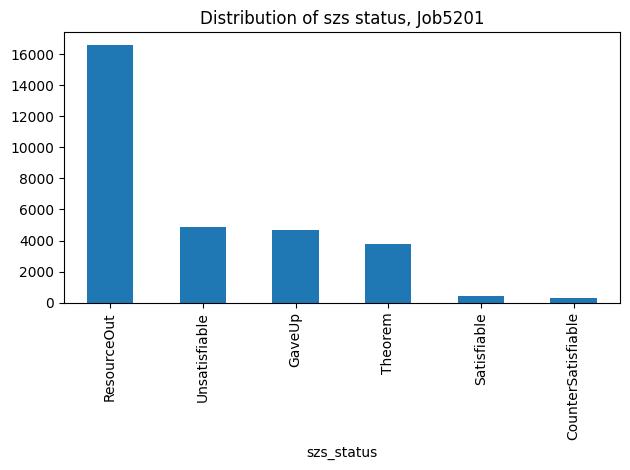

In [14]:

(
    df_se_indi["szs_status"]
    # [~df_se_indi["szs_status"].isin(["Inappropriate", "ResourceOut"])]
    .value_counts()
    .plot(kind="bar", title=f"Distribution of szs status, Job{job_index}")
)
plt.tight_layout()

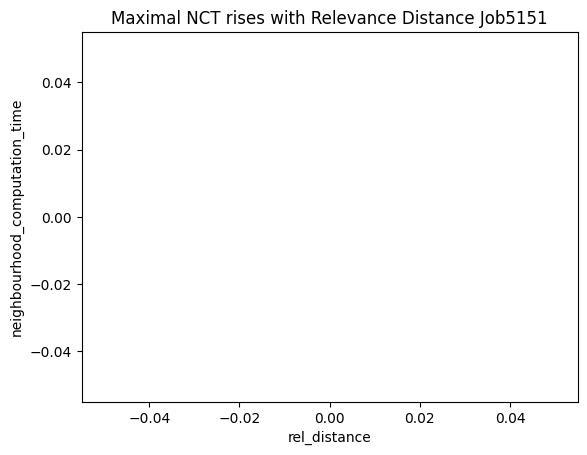

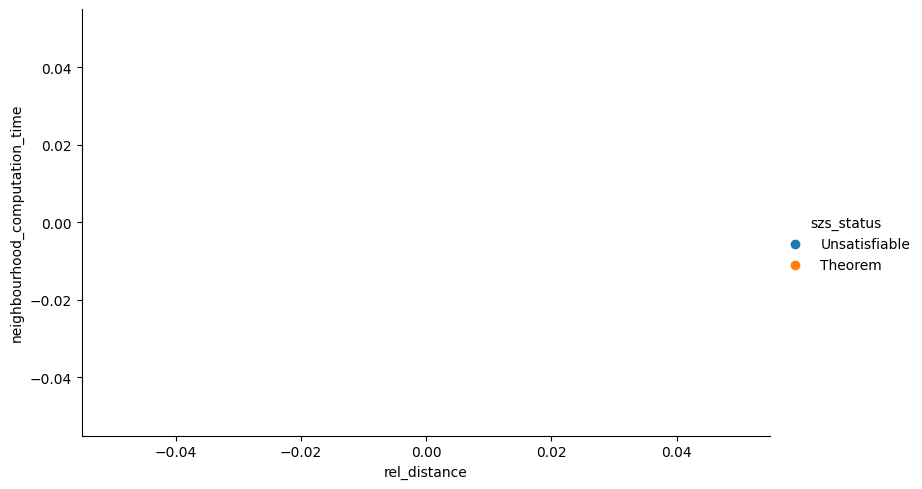

KeyError: 1899

In [13]:
from sklearn.linear_model import LinearRegression

df_filtered = (
    df_se_indi
    [
         (df_se_indi["szs_status"].isin(szs_statuses_for_evaluation))
    ]
    .reset_index(drop=True)
)

(
    df_filtered
    .plot
    .scatter(
        x="rel_distance",
        y="neighbourhood_computation_time",
        title=f"Maximal NCT rises with Relevance Distance Job{job_index}",
    )
)

fg = sns.FacetGrid(data=df_filtered, hue="szs_status", aspect=1.6, height=5)
fg.map(plt.scatter, 'rel_distance', 'neighbourhood_computation_time').add_legend()
plt.show()

print(df_filtered[df_filtered["initial_clauses"].isna()]["file_dir_name"][1899])

plt.tight_layout()
plt.show()
def compute_linear_regression(x_name, y_name):
    lr = LinearRegression()
    length = len(df_filtered)
    x = df_filtered[x_name].to_numpy()
    y = df_filtered[y_name].to_numpy()
    x = x.reshape(length, 1)
    y = y.reshape(length, 1)
    lr.fit(X=x, y=y)
    print(f"Linear Regression for {x_name} and {y_name}")
    print("Intercept: "+ str(lr.intercept_[0]))
    print("Coefficient: "+ str(lr.coef_[0][0]))

df_filtered = (
    df_filtered
    [df_filtered["initial_clauses"].notna()]
)
compute_linear_regression("initial_clauses", "graph_construction_time")
compute_linear_regression("rel_distance", "neighbourhood_computation_time")


df_filtered = df_filtered[["rel_distance", "neighbourhood_computation_time"]].pivot(columns="rel_distance")
df_filtered.columns = df_filtered.columns.droplevel()
df_filtered.boxplot().set_yscale("log")
plt.suptitle(f"NCT for different Relevance distances, Job{job_index}")
plt.show()

#### Evaluate mp_runs infos

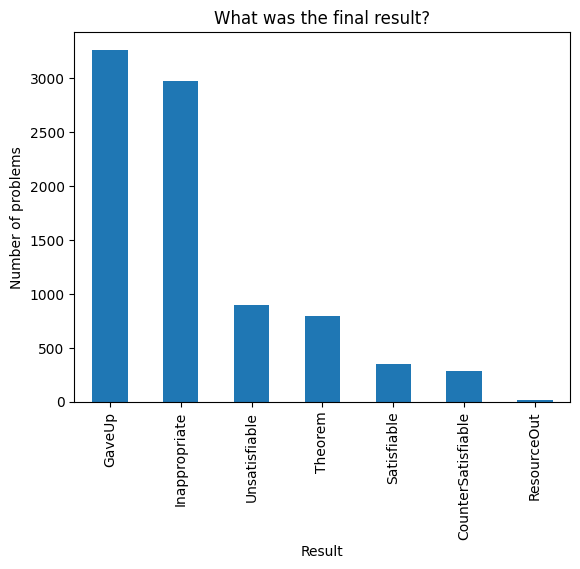

In [ ]:
(
    df_se_indi
    [df_se_indi["szs_status"].notnull()]
    ["szs_status"]
    .apply(lambda text: text.replace("SZS status ", ""))
    .value_counts()
    .sort_values(ascending=False)
    .plot(
        title="What was the final result?",
        xlabel="Result",
        ylabel="Number of problems",
        kind="bar",
    )
)
plt.show()

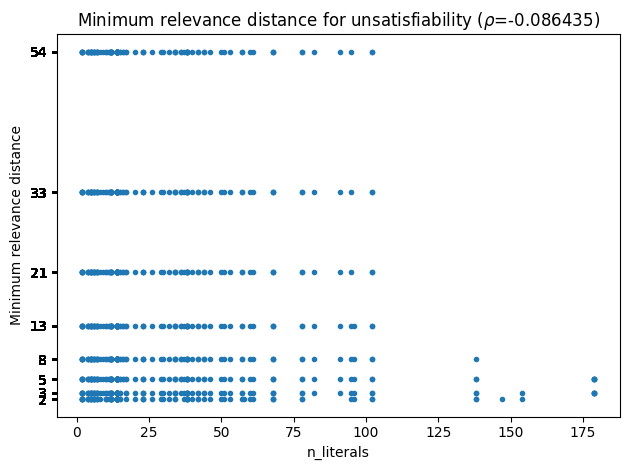

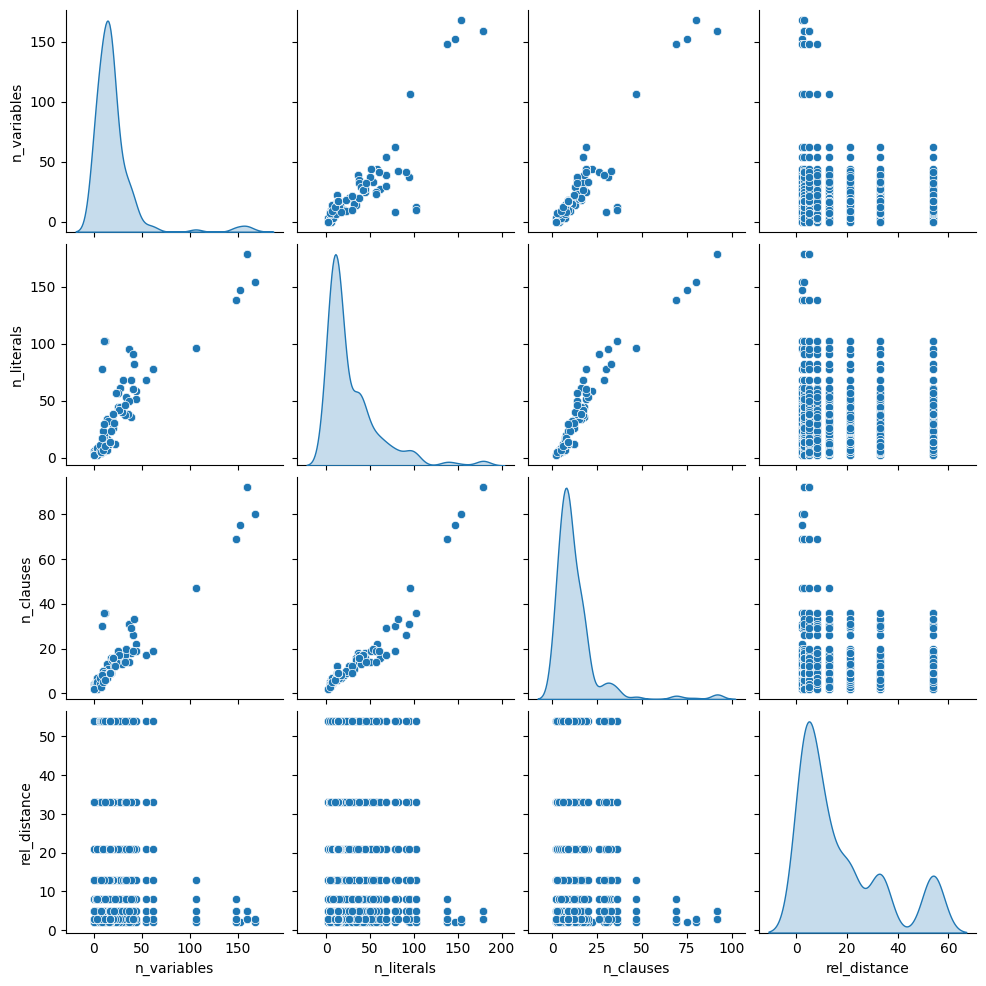

In [ ]:
import seaborn as sns
problem_parameters = ["n_formulae", "n_atoms", "n_variables", "n_literals", "n_clauses"]

df_tptp["problem"] =\
    df_tptp["Problem"].apply(lambda x: x[:x.rindex(".")])

df_merged = (
    df_se_indi
    [
        df_se_indi["szs_status"].notnull()
        & df_se_indi["szs_status"].str.contains("Unsatisfiable")
    ]
    [["problem", "rel_distance"]]
    .merge(
        df_tptp
        [problem_parameters+["problem"]],
        on="problem",
        how="inner"
    )
    [problem_parameters + ["rel_distance"]]
    .apply(lambda x: x[x.notnull() & x.notna()])
    .astype(float)
    .sort_values(by="rel_distance", ascending=True)
    .reset_index(drop=True)
)

parameter = "n_literals"
second_parameter = "rel_distance"
df_merged.plot(
    x=parameter,
    y=[second_parameter],
    style=".",
    ylabel="Minimum relevance distance",
    yticks=df_merged[second_parameter].to_list(),
    title="Minimum relevance distance for unsatisfiability ($\\rho$={:f})"\
        .format(df_merged[parameter].corr(df_merged[second_parameter])),
    legend=False,
)

plt.tight_layout()

sns.pairplot(df_merged.drop(labels=["n_formulae", "n_atoms"], axis=1), diag_kind="kde")

## Archive

#### Determine problems for profiling evaluation

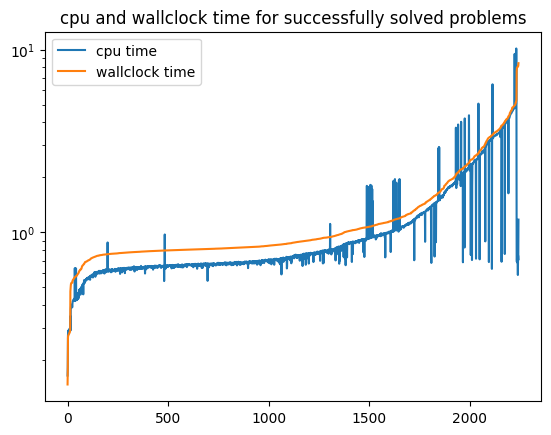

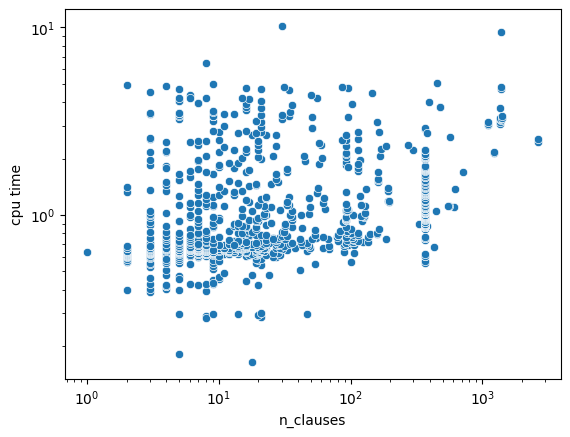

In [22]:
df_se_csv["problem"] = (
    df_se_csv["benchmark"]
    .apply(lambda x: x.split("/")[-1].split(".")[0])
)
df_tptp["problem"] = (
    df_tptp["Problem"]
    .apply(lambda x: x.split(".")[0])
)

"""
Index(['pair id', 'benchmark', 'benchmark id', 'solver', 'solver id',
       'configuration', 'configuration id', 'status', 'cpu time',
       'wallclock time', 'memory usage', 'result', 'expected', 'SZSResult',
       'SZSOutput', 'SZSStatus', 'problem', 'file_dir_name', 'python_version',
       'cpu_limit', 'pyres_version', 'rel_distance', 'graph_construction_time',
       'neighbourhood_computation_time', 'szs_status', 'initial_clauses',
       'processed_clauses', 'factors_computed', 'resolvents_computed',
       'tautologies_deleted', 'forward_subsumed', 'backward_subsumed',
       'user_time', 'system_time', 'total_time', 'Problem', 'spc',
       'n_formulae', 'n_atoms', 'n_clauses', 'n_literals', 'n_variables',
       'full_file_name'],
      dtype='object')
      """
df_merged = (
    df_se_csv
    .merge(df_se_indi, on="problem")
    .merge(df_tptp, on="problem")
    [["problem", "szs_status", "cpu time", "wallclock time", "graph_construction_time", "neighbourhood_computation_time",  "n_formulae", "n_atoms", "n_clauses", "processed_clauses", "n_literals", "n_variables", "factors_computed", "python_version", "pyres_version"]]
)
df_merged = df_merged[df_merged["szs_status"].isin(szs_statuses_for_evaluation)].sort_values("wallclock time").reset_index(drop=True)
df_merged[["cpu time", "wallclock time"]].plot()
plt.yscale("log")
plt.title("cpu and wallclock time for successfully solved problems")
plt.show()
sns.scatterplot(df_merged, x="n_clauses", y="cpu time")
plt.xscale("log")
plt.yscale("log")

#### Create Sankey diagram

In [ ]:
import plotly.graph_objects as go

read_from_csv = False
store = False
sankey_csv_path = problem_folder + "/sankey_data.csv"

if read_from_csv:
  df_filterings = pd.read_csv(sankey_csv_path, index_col=0)
else:
  filterings = [
    # (from, to, thickness),
    ("All", "Suitable for PyRes", suitable_ctr),
    ("All", "Unsuitable for PyRes", len(df_se_indi)-suitable_ctr),
    ("Suitable for PyRes", "Multiprocessing runs available", mp_runs_available_ctr),
    ("Suitable for PyRes", "Resource out", suitable_status_ctrs["Resource out"]),
    ("Suitable for PyRes", "Traceback", suitable_status_ctrs["Traceback"]),
    ("Suitable for PyRes", "Alarm Clock", suitable_status_ctrs["Alarm Clock"]),
    ("Suitable for PyRes", "SZS Status Inaproppriate", suitable_status_ctrs["SZS Status Inaproppriate"]),
  ]
  df_filterings = pd.DataFrame(filterings, columns=["source", "target", "value"])
  if store:
    df_filterings.to_csv(sankey_csv_path)

labels = np.unique(df_filterings[["source", "target"]].values).tolist()

for column_name in ["source", "target"]:
  df_filterings[column_name] =\
    df_filterings[column_name].apply(lambda x: labels.index(x))

sources, targets, values = [
  df_filterings[col].to_list()
  for col in
  df_filterings.columns
]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = "blue"
    ),
    link = dict(
      source = sources,
      target = targets,
      value = values,
))])
fig.show()



NameError: name 'suitable_ctr' is not defined

In [23]:
df_jobs.columns

Index(['job_index', 'python_version', 'pyres_version', 'atp_version',
       'total_runs', 'unique_solved_problems', 'ctr_Unsatisfiable',
       'ctr_GaveUp', 'ctr_Inappropriate', 'ctr_Satisfiable', 'ctr_Theorem',
       'ctr_ResourceOut', 'initial_clauses_mean', 'initial_clauses_std',
       'initial_clauses_min', 'initial_clauses_25%', 'initial_clauses_50%',
       'initial_clauses_75%', 'initial_clauses_max',
       'graph_construction_time_mean', 'graph_construction_time_std',
       'graph_construction_time_min', 'graph_construction_time_25%',
       'graph_construction_time_50%', 'graph_construction_time_75%',
       'graph_construction_time_max', 'neighbourhood_computation_time_mean',
       'neighbourhood_computation_time_std',
       'neighbourhood_computation_time_min',
       'neighbourhood_computation_time_25%',
       'neighbourhood_computation_time_50%',
       'neighbourhood_computation_time_75%',
       'neighbourhood_computation_time_max', 'rel_distance_values',
      

In [26]:
# df_jobs = pd.read_csv("df_jobs.csv", index_col=0)
df_jobs[
    ["job_index", "atp_version", "unique_solved_problems",
    "neighbourhood_computation_time_mean", "neighbourhood_computation_time_std",
    "graph_construction_time_mean", "graph_construction_time_std",
    "cpu time_mean", "cpu time_std",
    "wallclock time_mean", "wallclock time_std",
    "memory usage_mean", "memory usage_std",
    ]
].sort_values(by="atp_version", ascending=False)
# df_jobs.columns

,job_index,atp_version,unique_solved_problems,neighbourhood_computation_time_mean,neighbourhood_computation_time_std,graph_construction_time_mean,graph_construction_time_std,cpu time_mean,cpu time_std,wallclock time_mean,wallclock time_std,memory usage_mean,memory usage_std
0,5139,1.1.1,2072,0.019219,0.049924,0.367923,0.827027,1.432970,1.247368,1.556116,1.177924,274349.032627,24331.271538
1,5151,0.0.0,2306,NaN,NaN,NaN,NaN,1.128424,0.923185,1.299745,0.989692,276801.357607,36273.802279
